In [115]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import os
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [116]:
# def read_csv_file(file_path):
#     try:
#         df = pd.read_csv(file_path)
#         return df
#     except pd.errors.EmptyDataError:
#         print(f"Warning: Empty CSV file found at {file_path}")
#         return None
#     except pd.errors.ParserError:
#         print(f"Error: Invalid CSV file found at {file_path}")
#         return None

# # Set the folder path containing the gesture CSV files
# gesture_folder_path = '../output/gesture'

# # Create an empty list to store the dataframes for each CSV file
# dataframes = []

# # Iterate over each file in the gesture folder
# for file_name in os.listdir(gesture_folder_path):
#     if file_name.endswith('.csv'):
#         file_path = os.path.join(gesture_folder_path, file_name)

#         # Read the CSV file into a dataframe or handle exceptions
#         df = read_csv_file(file_path)
#         if df is not None:
#             # Add a new column 'video_name' based on the file name
#             df['video_name'] = file_name
            
#             # Add a new column 'label' based on the file name condition
#             df['label'] = 0 if file_name.startswith('4') else 1
            
#             dataframes.append(df)

# # Concatenate all dataframes into a single consolidated dataframe
# consolidated_data = pd.concat(dataframes, ignore_index=True)
# consolidated_data.to_csv('../output/gesture/comsolidated_data.csv')

1. Data Preparation

In [161]:
consolidated_data = pd.read_csv('../output/gesture/comsolidated_data.csv')

In [162]:
consolidated_data.columns

Index(['Unnamed: 0', 'time_in_seconds', 'frame', 'total_movement_per_second',
       'pose_openness', 'leaning', 'head_horizontal', 'head_vertical',
       'left_arm_angle', 'left_arm_v_movement', 'left_arm_h_movement',
       'right_arm_angle', 'right_arm_v_movement', 'right_arm_h_movement',
       'left_hand_orientation', 'left_hand_state', 'right_hand_orientation',
       'right_hand_state', 'video_name', 'label'],
      dtype='object')

In [163]:
# Deal with empty value 

# drop left_arm_v_movement and right_arm_v_movement, due to ~10% empty value 
data_dropped = consolidated_data.drop(columns=['left_arm_v_movement', 'right_arm_v_movement'])
# Deal with empty value
data_filled = data_dropped.copy()
mask = data_filled['video_name'].shift() == data_filled['video_name']
data_filled.loc[mask] = data_filled.loc[mask].fillna(method='ffill')
# Drop rows with null values inside
data_filled = data_filled.dropna()

In [164]:
# feature engineering 
data_encoded = data_filled.copy()
# Calculate body symmetry feature
# data_encoded['arm_angle_symmetry'] = data_encoded['left_arm_angle'] - data_encoded['right_arm_angle']
# data_encoded['arm_h_movement_symmetry'] = np.where(data_encoded['left_arm_h_movement'] == data_encoded['right_arm_h_movement'], 1, 0)
# data_encoded['hand_orientation_symmetry'] = np.where(data_encoded['left_hand_orientation'] == data_encoded['right_hand_orientation'], 1, 0)
# data_encoded['hand_state_symmetry'] = np.where(data_encoded['left_hand_state'] == data_encoded['right_hand_state'], 1, 0)
# data_encoded['total_movement_change'] = data_encoded['total_movement_per_second'].diff(periods=window_size)
# Drop rows with NaN values resulting from the temporal changes calculation
# data_encoded.dropna(inplace=True)

In [165]:
# drop the high correlated columns 
dropped_cols = [
                'left_hand_state',
                'right_hand_state'
                ]
data_dropped = data_encoded.drop(columns=dropped_cols)

In [167]:
# One hot encoding 
categorical_cols = ['leaning',
                    'head_horizontal', 
                    'head_vertical', 
                    'left_arm_h_movement',
                    'right_arm_h_movement',
                    'left_hand_orientation',
                    'right_hand_orientation'
                    ]
# Apply one-hot encoding to the selected categorical columns
data_one_hot = pd.get_dummies(data_dropped, columns=categorical_cols)

In [170]:
# drop duplicate columns
dup_cols = ['leaning_Backward',
            'head_horizontal_STILL',
            'head_vertical_STILL',
            'left_arm_h_movement_CALCULATING',
            'right_arm_h_movement_CALCULATING']
data_processed = data_one_hot.drop(columns=dup_cols)

In [171]:
data_processed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10641 entries, 0 to 10653
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    10641 non-null  int64  
 1   time_in_seconds               10641 non-null  float64
 2   frame                         10641 non-null  int64  
 3   total_movement_per_second     10641 non-null  float64
 4   pose_openness                 10641 non-null  float64
 5   left_arm_angle                10641 non-null  float64
 6   right_arm_angle               10641 non-null  float64
 7   video_name                    10641 non-null  object 
 8   label                         10641 non-null  int64  
 9   leaning_Forward               10641 non-null  bool   
 10  head_horizontal_LEFT          10641 non-null  bool   
 11  head_horizontal_RIGHT         10641 non-null  bool   
 12  head_vertical_DOWN            10641 non-null  bool   
 13  head_v

In [172]:
# Scaling 
numerical_cols = ['total_movement_per_second', 'pose_openness']
# Apply normalization scaling to the selected numerical columns
scaler = MinMaxScaler()
data_processed[numerical_cols] = scaler.fit_transform(data_processed[numerical_cols])


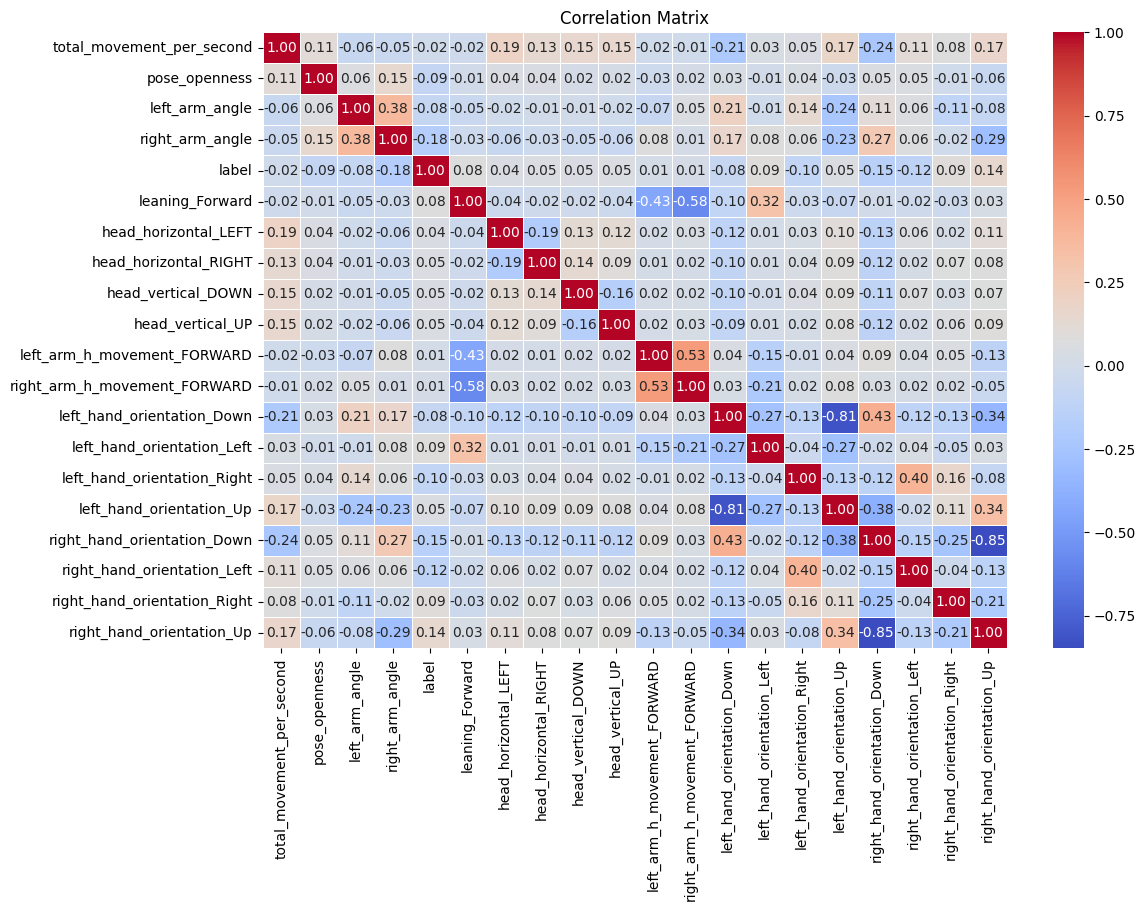

In [173]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

data_corr = data_processed.drop(columns=['video_name', 'Unnamed: 0','time_in_seconds', 'frame'])
# Calculate correlation matrix
correlation_matrix = data_corr.corr()

# Plot correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

A random forest model

In [174]:
data_processed.columns

Index(['Unnamed: 0', 'time_in_seconds', 'frame', 'total_movement_per_second',
       'pose_openness', 'left_arm_angle', 'right_arm_angle', 'video_name',
       'label', 'leaning_Forward', 'head_horizontal_LEFT',
       'head_horizontal_RIGHT', 'head_vertical_DOWN', 'head_vertical_UP',
       'left_arm_h_movement_FORWARD', 'right_arm_h_movement_FORWARD',
       'left_hand_orientation_Down', 'left_hand_orientation_Left',
       'left_hand_orientation_Right', 'left_hand_orientation_Up',
       'right_hand_orientation_Down', 'right_hand_orientation_Left',
       'right_hand_orientation_Right', 'right_hand_orientation_Up'],
      dtype='object')

In [175]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix

# Split the data into features (X) and target (y)
X = data_processed.drop(['time_in_seconds', 'frame', 'video_name', 'label', 'Unnamed: 0'], axis=1)
y = data_processed['label']
video_names = data_processed['video_name']

# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Create GroupShuffleSplit with test size and random state
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Split the data into training and testing sets based on video_names
train_indices, test_indices = next(gss.split(X, y, groups=video_names))

# Split the data based on the indices
X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]
video_names_train, video_names_test = video_names.iloc[train_indices], video_names.iloc[test_indices]

# Train the model on the training set
rf_model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = rf_model.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy based on the gesture at each second: {accuracy}")
confusion_mat = confusion_matrix(y_test, y_pred)

# Convert the confusion matrix to a DataFrame for better visualization
confusion_df = pd.DataFrame(confusion_mat, index=['Actual Negative', 'Actual Positive'],
                             columns=['Predicted Negative', 'Predicted Positive'])

print(confusion_df)


Accuracy based on the gesture at each second: 0.5912783240701154
                 Predicted Negative  Predicted Positive
Actual Negative                 649                 572
Actual Positive                 384                 734


In [176]:
# Create a DataFrame to hold the video-level predictions and labels
video_results = pd.DataFrame({'video_name': video_names_test, 'label': y_test, 'prediction': y_pred})

# Group the predictions by video_name and calculate the majority vote
video_predictions = video_results.groupby('video_name')['prediction'].apply(
    lambda x: mode(x)[0][0] if len(x.unique()) > 1 else x.iloc[0]
)

# Get the true video labels
video_labels = video_results.groupby('video_name')['label'].apply(lambda x: x.iloc[0])

# Calculate the accuracy at the video_name level
video_accuracy = (video_predictions == video_labels).mean()
print(f"Accuracy at the video_name level: {video_accuracy}")
true_false_table = pd.crosstab(video_labels, video_predictions, rownames=['Actual'], colnames=['Predicted'])

print(true_false_table)


Accuracy at the video_name level: 0.625
Predicted  0  1
Actual         
0          3  1
1          2  2


C:\Users\rcz8260\AppData\Local\Temp\ipykernel_46900\2869649305.py:6: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  lambda x: mode(x)[0][0] if len(x.unique()) > 1 else x.iloc[0]


In [177]:
video_labels

video_name
11008.1-cut-5min-gesture.csv            1
3005 12m clin-cut-5min-gesture.csv      1
3023 12m pt1-cut-5min-gesture.csv       1
3034redo1post-cut-gesture.csv           1
4004 baseline-cut-5min-gesture.csv      0
4005 clinical 1-cut-5min-gesture.csv    0
4007 and 12001-cut-5min-gesture.csv     0
4056_1post-cut-gesture.csv              0
Name: label, dtype: int64

In [178]:
video_predictions

video_name
11008.1-cut-5min-gesture.csv            0
3005 12m clin-cut-5min-gesture.csv      1
3023 12m pt1-cut-5min-gesture.csv       1
3034redo1post-cut-gesture.csv           0
4004 baseline-cut-5min-gesture.csv      0
4005 clinical 1-cut-5min-gesture.csv    0
4007 and 12001-cut-5min-gesture.csv     0
4056_1post-cut-gesture.csv              1
Name: prediction, dtype: int64